# GRU(Gate Recurrent Unit) Network on Predicting Stock Price

In [1]:
import torch
from torch import nn, optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from ta import momentum

# Set device: GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the test dataset

In [3]:
# Load test data
data_test = pd.read_csv('./dataset/val.csv')
data_test = data_test.dropna()
data_test['Date'] = pd.to_datetime(data_test['Date'])
data_test['Close'] = data_test['Close'].astype(float)

In [4]:
data_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-08,2183.760010,2185.439941,2177.850098,2180.889893,2180.889893,3327550000
1,2016-08-09,2182.239990,2187.659912,2178.610107,2181.739990,2181.739990,3334300000
2,2016-08-10,2182.810059,2183.409912,2172.000000,2175.489990,2175.489990,3254950000
3,2016-08-11,2177.969971,2188.449951,2177.969971,2185.790039,2185.790039,3423160000
4,2016-08-12,2183.739990,2186.280029,2179.419922,2184.050049,2184.050049,3000660000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806 entries, 0 to 805
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       806 non-null    datetime64[ns]
 1   Open       806 non-null    float64       
 2   High       806 non-null    float64       
 3   Low        806 non-null    float64       
 4   Close      806 non-null    float64       
 5   Adj Close  806 non-null    float64       
 6   Volume     806 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 44.2 KB


<Axes: >

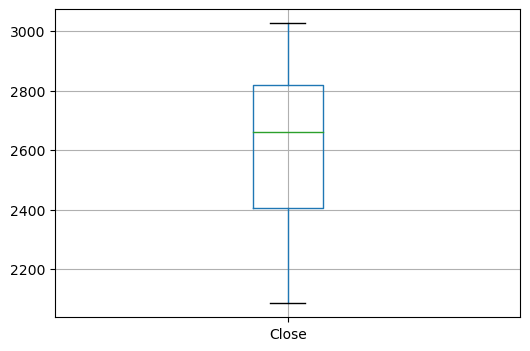

In [5]:
data_test.info()
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
data_test.boxplot(column=['Close'])

In [6]:
data_test.shape

(806, 7)

# Prepare the input sequence for GRU model

In [7]:
#test set
# Add technical indicators as features
data_test['SMA_5'] = data_test['Close'].rolling(window=5).mean()
data_test['SMA_10'] = data_test['Close'].rolling(window=10).mean()
data_test['RSI'] = momentum.rsi(data_test['Close'], window=14)
# Delete rows corresponding to missing values
data_test = data_test.dropna()

## MinMaxScaler

In [8]:
#test set
scaler = MinMaxScaler()
data_test[['Close', 'SMA_5', 'SMA_10', 'RSI']] = scaler.fit_transform(data_test[['Close', 'SMA_5', 'SMA_10', 'RSI']])

X_test = data_test[['Close', 'SMA_5', 'SMA_10', 'RSI']].values[:-1]
y_test = data_test['Close'].values[1:]

X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

X_test = X_test.view(-1, 1, 4).to(device)
y_test = y_test.view(-1, 1).to(device)


# Load pre-trained model

In [9]:
# Define GRU model
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, _ = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 1)  # resize into (batch_size, 1, 1)
        return out

In [14]:
input_dim = 4  # The input dimension is 4, which is the number of features
hidden_dim = 32
output_dim = 1
num_layers = 2

In [15]:
model = GRU(input_dim, hidden_dim, output_dim, num_layers).to(device)
model.load_state_dict(torch.load('gru_model.pth'))
model

GRU(
  (gru): GRU(4, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

## Evaluate on the test set

In [18]:
########Evaluate model
model.eval()  # Switch to evaluation mode
with torch.no_grad():
    predicted = model(X_test)
    predicted = scaler.inverse_transform(np.repeat(predicted.cpu().numpy(), 4, axis=1))  # Denormalize and reshape
    actual = scaler.inverse_transform(np.repeat(y_test.cpu().numpy(), 4, axis=1)) # Denormalize and reshape

## Backtest

In [19]:
def backtest(predictions, original_prices, threshold=0.015, initial_cash=500000):
    """
    Backtest function to simulate trading based on the model's predictions.

    :param predictions: The predicted prices from the model.
    :param original_prices: The actual prices of the stock.
    :param threshold: The threshold for making a trade decision.
    :param initial_cash: The initial cash in the portfolio.
    :return: The final portfolio value and the total return.
    """
    cash = initial_cash
    shares = 0
    total_assets = initial_cash

    for i in range(1, len(predictions)):
        predicted_change = (predictions[i] - original_prices[i - 1]) / original_prices[i - 1]
        actual_change = (original_prices[i] - original_prices[i - 1]) / original_prices[i - 1]

        # Decision to buy
        if predicted_change > threshold and cash >= original_prices[i]:
            shares_bought = cash // original_prices[i]
            shares += shares_bought
            cash -= shares_bought * original_prices[i]

        # Decision to sell
        elif predicted_change < -threshold and shares > 0:
            cash += shares * original_prices[i]
            shares = 0

        # Update total assets value
        total_assets = cash + shares * original_prices[i]

    total_return = total_assets - initial_cash
    return total_assets, total_return

In [20]:
initial_cash = 500000
threshold = 0.015
# Applying the backtest function to the LSTM model's predictions
final_assets, total_return = backtest(predicted[:, 0],actual[:, 0], threshold=threshold, initial_cash=initial_cash)
return_rate = (total_return/initial_cash)*100
print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:",return_rate)

Final Assets: 664834.4829101562 Total Return: 164834.48291015625 Return Rate: 32.966896582031254
